# Power Law Sandbox

Code authored by: Shaw Talebi <br>
Article link: https://medium.com/towards-data-science/pareto-power-laws-and-fat-tails-0355a187ee6a

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

from scipy.stats import kurtosis, entropy, pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.linear_model import LogisticRegression

np.random.seed(1)

### Gaussian

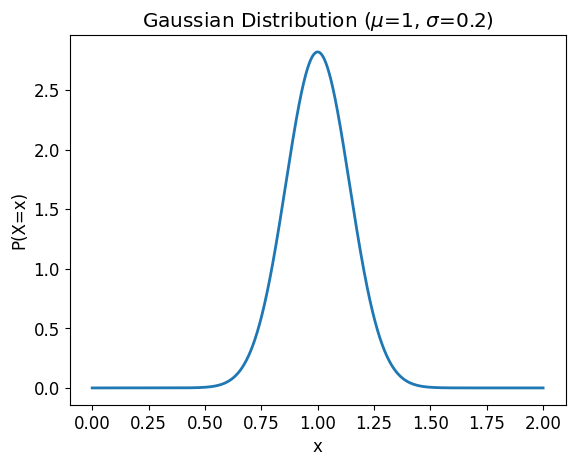

In [2]:
def gaussian_dist(m, s, x):
    return (1/(s*np.sqrt(np.pi)))*np.exp(-((x-m)/s)**2)

x = np.linspace(0, 2, 10000)

plt.rcParams.update({'font.size': 12})
plt.plot(x, gaussian_dist(1,0.2,x), linewidth=2)
plt.title(r'Gaussian Distribution ($\mu$=1, $\sigma$=0.2)')
plt.ylabel("P(X=x)")
plt.xlabel("x")
plt.savefig("images/gaussian.png")

### Pareto Distribution

In [3]:
def pareto_dist(a, x):
    # x_min = 1
    return a*np.power(x, -(a+1))

def pareto_surv_func(a, x):
    # x_min = 1
    return a*np.power(x, -a)

def pareto_mean(a):
    # x_min = 1
    return a/(a-1)

In [4]:
n = 100_000
a = 1.16
x_min = 1
x = np.linspace(x_min, 10, n+1)

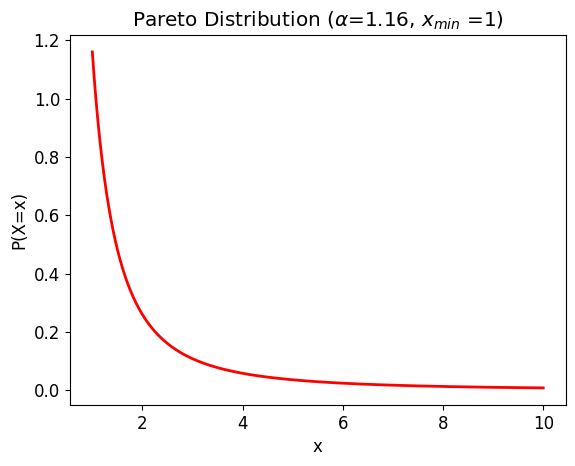

In [5]:
plt.plot(x, pareto_dist(a,x), 'r', linewidth=2)
plt.title(r'Pareto Distribution ($\alpha$=' + str(a) + ', $x_{min}$ =1)')
plt.ylabel("P(X=x)")
plt.xlabel("x")
plt.savefig("images/pareto.png")

### Power Laws

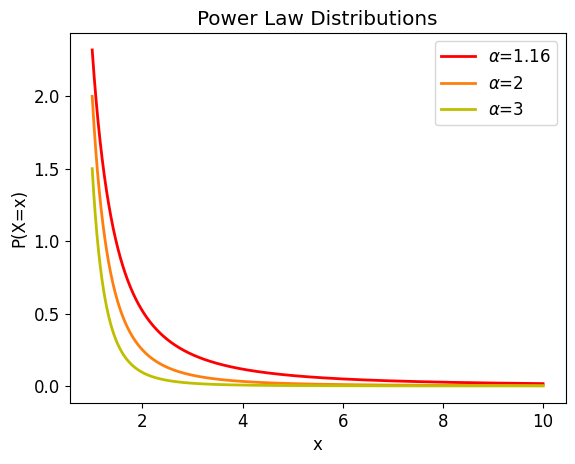

In [6]:
x = np.linspace(x_min, 10, n+1)
plt.plot(x, 2*pareto_dist(a,x), 'r', linewidth=2, label= r'$\alpha$=' + str(a))
plt.plot(x, pareto_dist(2,x), color='#ff7f0e', linewidth=2, label= r'$\alpha$=' + str(2))
plt.plot(x, 0.5*pareto_dist(3,x), 'y', linewidth=2, label= r'$\alpha$=' + str(3))
plt.title("Power Law Distributions")
plt.ylabel("P(X=x)")
plt.xlabel("x")
plt.legend()
plt.savefig("images/power_laws.png")

### Problem 1: Unstable Statistical Quantities

#### Unstable mean

In [7]:
a = 2
n = 100_000
x = np.linspace(0, n, n+1)

In [8]:
s_pareto = (np.random.pareto(a, len(x)) + 1) * x_min
true_mean = pareto_mean(a)
s_gaussian = (np.random.normal(true_mean, true_mean/10, len(x)))

sample_means = np.zeros((len(x),2))

t0 = time.time()
for i in range(len(x)):
    sample_means[i,0] = np.mean(s_gaussian[:i+1])
    sample_means[i,1] = np.mean(s_pareto[:i+1])

    
t1 = time.time()
dt = t1-t0
print(dt)

3.0135700702667236


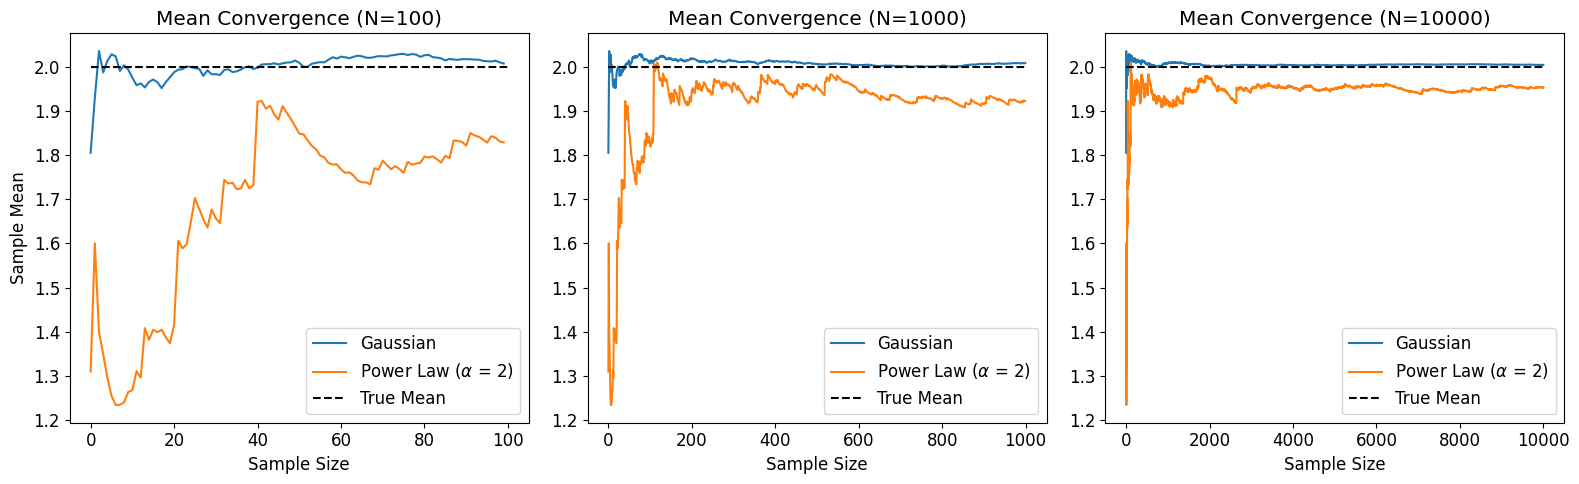

In [9]:
plt.rcParams.update({'font.size': 12})

scale_list = [1/1000, 1/100, 1/10, 1]
scale_list = [1/1000, 1/100, 1/10]

plt.figure(figsize=(16, 5))
for j in range(len(scale_list)):
    plt.subplot(1,len(scale_list),j+1)
    plt.plot(x[:int(n*scale_list[j])], sample_means[:int(n*scale_list[j])])
    plt.plot([x[0], x[int(n*scale_list[j])]], [true_mean, true_mean], 'k--')
    plt.legend(["Gaussian", r'Power Law ($\alpha$ = ' + str(a) + ")", "True Mean"])
    plt.title("Mean Convergence (N=" + str(int(n*scale_list[j])) + ")")
    plt.xlabel("Sample Size")
    if j==0:
        plt.ylabel("Sample Mean")

    # plt.show()
plt.tight_layout()
plt.savefig("images/mean_convergence.png")

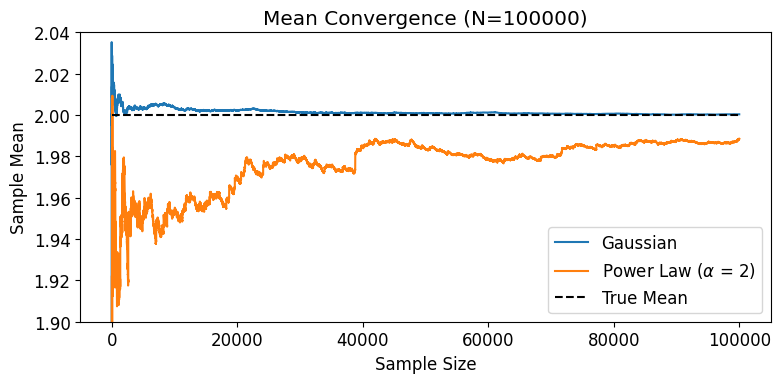

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(x, sample_means)
plt.plot([x[0], x[-1]], [true_mean, true_mean], 'k--')
plt.legend(["Gaussian", r'Power Law ($\alpha$ = ' + str(a) + ")", "True Mean"])
plt.title("Mean Convergence (N=" + str(n) + ")")
plt.xlabel("Sample Size")
plt.ylabel("Sample Mean")
plt.ylim(1.9, 2.04)
plt.tight_layout()
# plt.show()
plt.savefig("images/mean_convergence_n="+ str(n)+".png")

#### other unstable metrics

In [11]:
n = 10_000
x = np.linspace(0, n, n+1)

In [12]:
s_pareto = (np.random.pareto(a, len(x)) + 1) * x_min

metric_names_list = ['Median', '$\sigma$', '$\sigma^2$', 'Min', 'Max', '1st\n Percentile', '99th\n Percentile', 'Kurtosis', 'Entropy']
sample_metrics = np.zeros((len(x),len(metric_names_list)))

t0 = time.time()
for i in range(len(x)):
    sample_metrics[i,0] = np.median(s_pareto[:i+1])
    sample_metrics[i,1] = np.std(s_pareto[:i+1])
    sample_metrics[i,2] = np.var(s_pareto[:i+1])
    sample_metrics[i,3] = np.min(s_pareto[:i+1])
    sample_metrics[i,4] = np.max(s_pareto[:i+1])
    sample_metrics[i,5] = np.quantile(s_pareto[:i+1],0.01)
    sample_metrics[i,6] = np.quantile(s_pareto[:i+1],0.99)
    sample_metrics[i,7] = kurtosis(s_pareto[:i+1])
    sample_metrics[i,8] = entropy(s_pareto[:i+1])
t1 = time.time()
dt = t1-t0
print(dt)

4.349138259887695


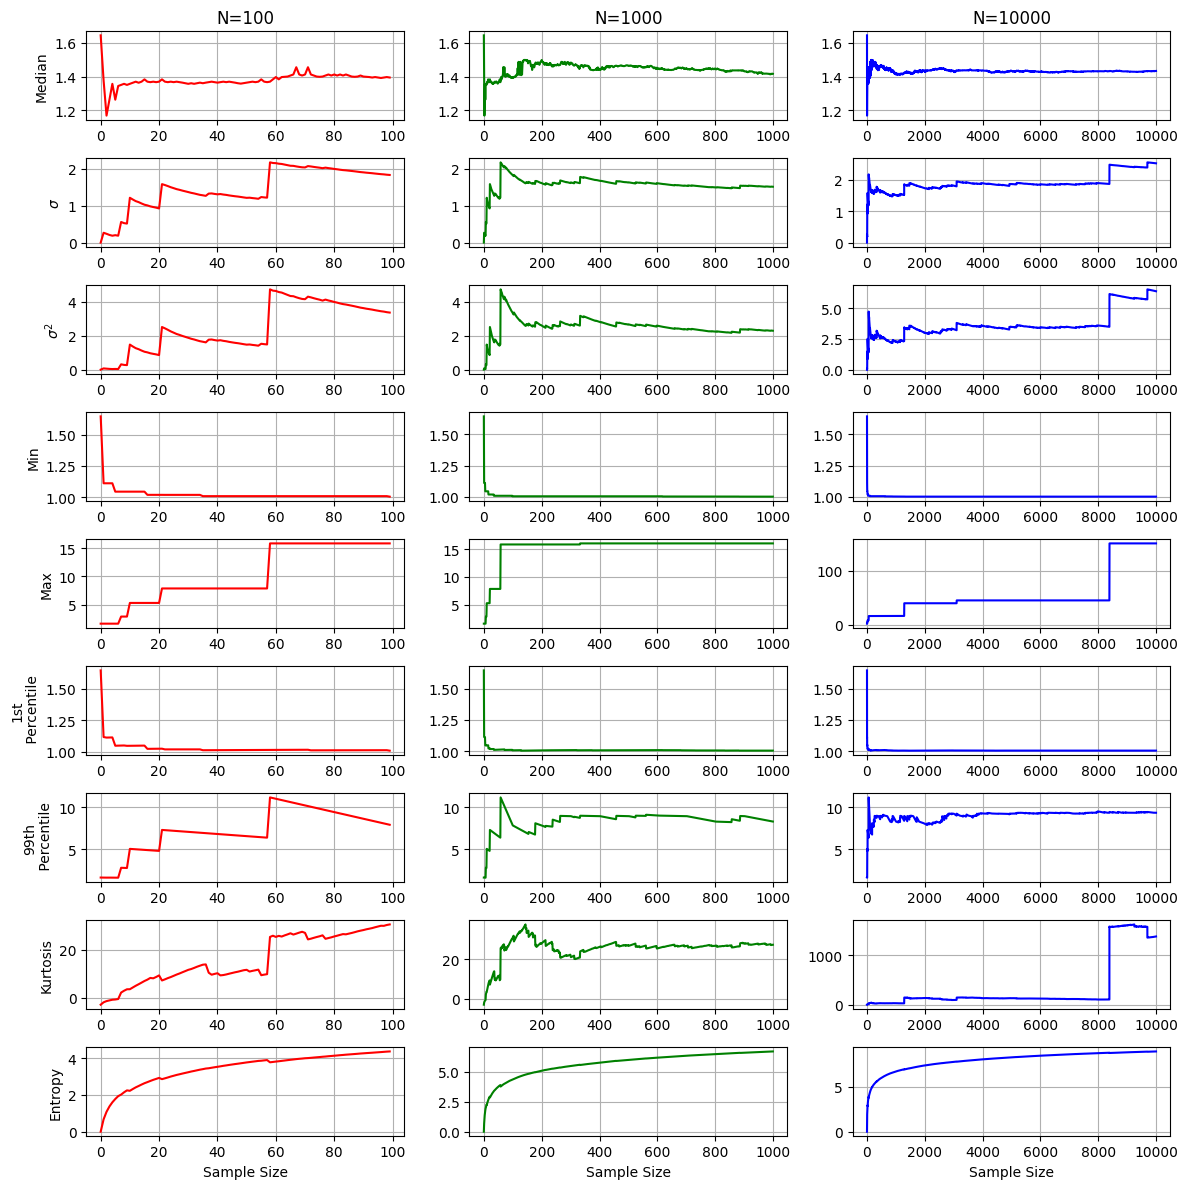

In [13]:
plt.rcParams.update({'font.size': 10})

scale_list = [1/100, 1/10, 1]
color_list = ['r', 'g', 'b']

plt.figure(figsize=(12,12))
for i in range(len(metric_names_list)):
    for j in range(len(scale_list)):
    
        plt.subplot(len(metric_names_list), len(scale_list), len(scale_list)*i+(j+1))
        plt.plot(x[:int(n*scale_list[j])], sample_metrics[:int(n*scale_list[j]),i], color_list[j])
        plt.grid()
        if j==0:
            plt.ylabel(metric_names_list[i])
        if i==0:
            plt.title("N=" + str(int(n*scale_list[j])))
        if i==len(metric_names_list)-1:
            plt.xlabel("Sample Size")
plt.tight_layout()
plt.savefig("images/other_metric_convergence.png")

### Problem 2: Regression

#### Small sample size

In [14]:
N = 100
a = 2
s_pareto = (np.random.pareto(a, N) + 1) * x_min
s_gaussian = np.random.normal(pareto_mean(a), 1, len(s_pareto))

In [15]:
def linear_func_w_noise(m, b, x, n):
    return m*x + b + n

m = 2
b = 1

(array([ 3.,  4.,  7., 16., 24., 18., 16.,  3.,  5.,  4.]),
 array([ 1.39800211,  2.51662925,  3.63525639,  4.75388353,  5.87251067,
         6.99113781,  8.10976495,  9.22839209, 10.34701923, 11.46564637,
        12.58427351]),
 <BarContainer object of 10 artists>)

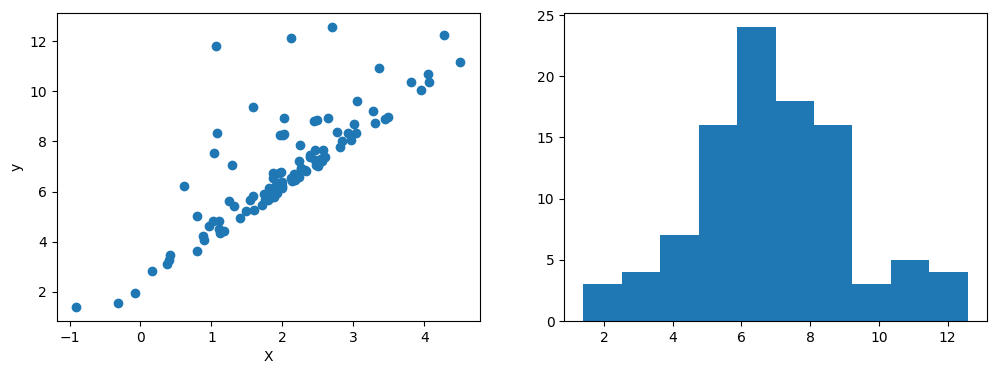

In [16]:
X = s_gaussian.reshape(-1, 1)
y = linear_func_w_noise(m, b, s_gaussian, s_pareto)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(X,y)
plt.xlabel("X")
plt.ylabel("y")
plt.subplot(1,2,2)
plt.hist(y)

In [17]:
reg = LinearRegression().fit(X.reshape(-1, 1), y)
reg.score(X, y)

print('R^2 = '  + str(reg.score(X, y)))
print('m = '  + str(reg.coef_[0]))

R^2 = 0.6665272588133665
m = 1.8674195769946542


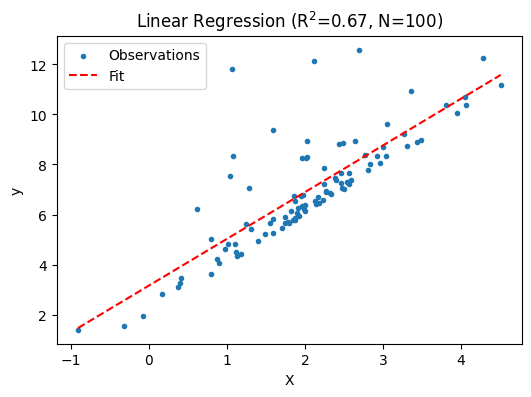

In [18]:
plt.figure(figsize=(6,4))
plt.scatter(X,y, marker='.')
plt.plot([np.min(X), np.max(X)],[reg.predict(X)[np.argmin(X)], reg.predict(X)[np.argmax(X)]], 'r--')
plt.title("Linear Regression (R$^2$="  + str(np.round(reg.score(X, y),2)) + ", N=100)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(['Observations', 'Fit'])
plt.savefig("images/linear_regression-n=1000.png")

#### Larger sample size

In [19]:
N = 100_000_000
s_pareto = (np.random.pareto(a, N) + 1) * x_min
s_gaussian = np.random.normal(pareto_mean(a), 1, len(s_pareto))

X = s_gaussian.reshape(-1, 1)
y = linear_func_w_noise(m, b, s_gaussian, s_pareto)

print(r2_score(y, reg.predict(X)))

0.21596421178947767


In [20]:
score_array = np.zeros(8,)

for p in range(len(score_array)):
    X_temp = X[:int(10**(p+1))]
    y_temp = y[:int(10**(p+1))]
    
    score_array[p] = LinearRegression().fit(X_temp, y_temp).score(X_temp, y_temp)

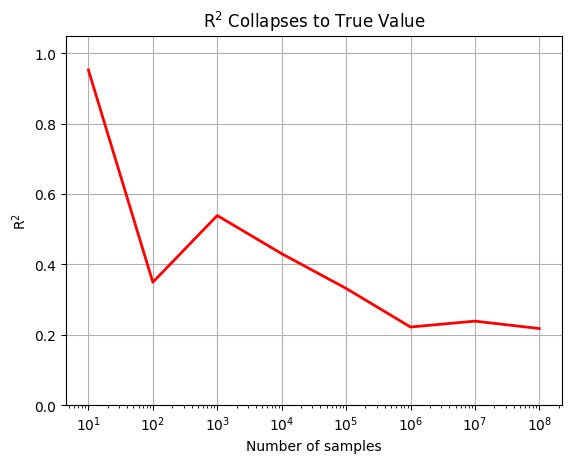

In [21]:
plt.semilogx(10**np.linspace(1, len(score_array), len(score_array)), score_array, 'r', linewidth=2)
plt.xlabel("Number of samples")
plt.ylabel("R$^2$")
plt.title("R$^2$ Collapses to True Value")
plt.ylim(0,1.05)
plt.grid()
plt.savefig("images/r2-vs-n.png")

### More Distributions

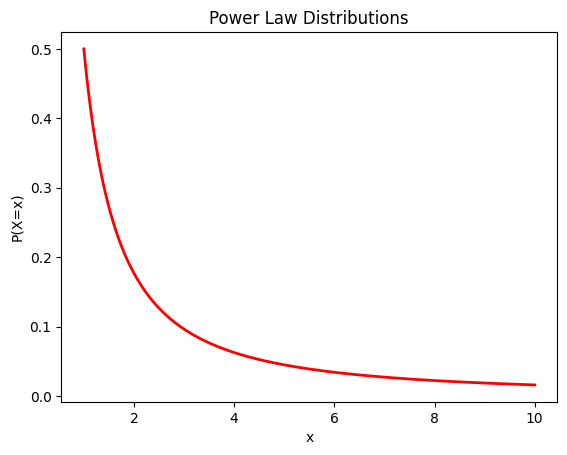

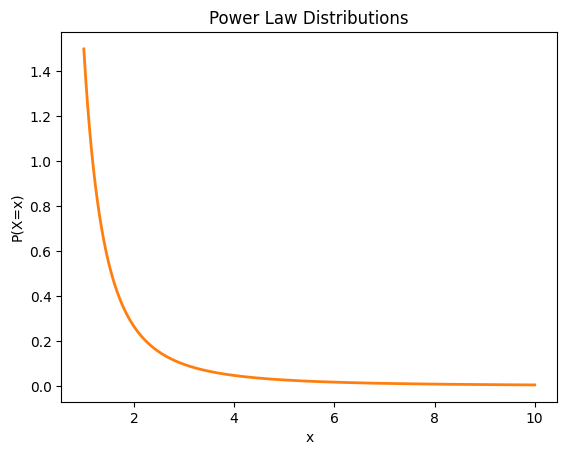

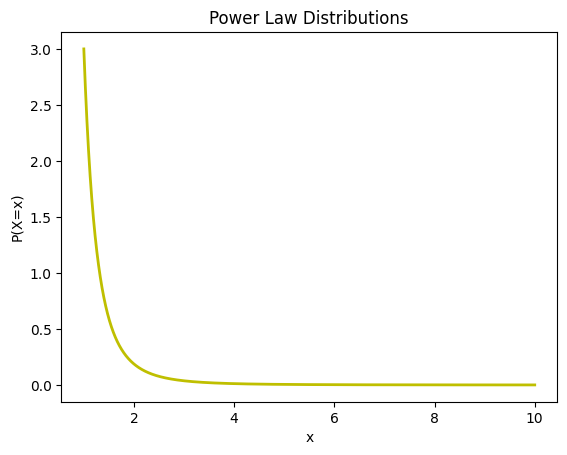

In [22]:
x = np.linspace(x_min, 10, n+1)

a_list = [0.5, 1.5, 3]
color_list = ['r', '#ff7f0e', 'y']

for i in range(len(a_list)):
    plt.plot(x, pareto_dist(a_list[i],x), color_list[i], linewidth=2)
    # plt.plot(x, pareto_dist(2,x), color='#ff7f0e', linewidth=2, label= r'$\alpha$=' + str(2))
    # plt.plot(x, 0.5*pareto_dist(3,x), 'y', linewidth=2, label= r'$\alpha$=' + str(3))
    plt.title("Power Law Distributions")
    plt.ylabel("P(X=x)")
    plt.xlabel("x")
    plt.savefig("images/power_law_a="+str(a_list[i])+".png")
    plt.show()

/var/folders/zq/chlgfdlj6xj0bpc5_zcmgkf00000gn/T/ipykernel_9446/369590344.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return (1/(x*s*np.sqrt(np.pi)))*np.exp(-((np.log(x)-m)**2/(2*s**2)))
/var/folders/zq/chlgfdlj6xj0bpc5_zcmgkf00000gn/T/ipykernel_9446/369590344.py:2: RuntimeWarning: divide by zero encountered in log
  return (1/(x*s*np.sqrt(np.pi)))*np.exp(-((np.log(x)-m)**2/(2*s**2)))
/var/folders/zq/chlgfdlj6xj0bpc5_zcmgkf00000gn/T/ipykernel_9446/369590344.py:2: RuntimeWarning: invalid value encountered in multiply
  return (1/(x*s*np.sqrt(np.pi)))*np.exp(-((np.log(x)-m)**2/(2*s**2)))


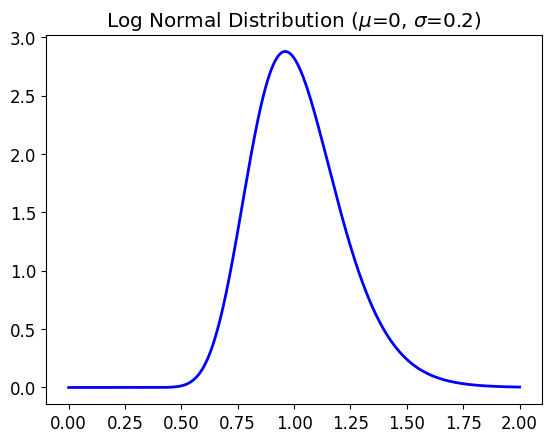

In [23]:
def log_normal_dist(m, s, x):
    return (1/(x*s*np.sqrt(np.pi)))*np.exp(-((np.log(x)-m)**2/(2*s**2)))

x = np.linspace(0, 2, 10000)
m=0
s=0.2

plt.rcParams.update({'font.size': 12})
plt.plot(x, log_normal_dist(m,s,x), 'b', linewidth=2)
plt.title("Log Normal Distribution")
plt.title(r'Log Normal Distribution ($\mu$='+ str(m) +', $\sigma$='+str(s)+')')
plt.savefig("images/log-normal_distribution_s="+str(s)+".png")

/var/folders/zq/chlgfdlj6xj0bpc5_zcmgkf00000gn/T/ipykernel_9446/369590344.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return (1/(x*s*np.sqrt(np.pi)))*np.exp(-((np.log(x)-m)**2/(2*s**2)))
/var/folders/zq/chlgfdlj6xj0bpc5_zcmgkf00000gn/T/ipykernel_9446/369590344.py:2: RuntimeWarning: divide by zero encountered in log
  return (1/(x*s*np.sqrt(np.pi)))*np.exp(-((np.log(x)-m)**2/(2*s**2)))
/var/folders/zq/chlgfdlj6xj0bpc5_zcmgkf00000gn/T/ipykernel_9446/369590344.py:2: RuntimeWarning: invalid value encountered in multiply
  return (1/(x*s*np.sqrt(np.pi)))*np.exp(-((np.log(x)-m)**2/(2*s**2)))


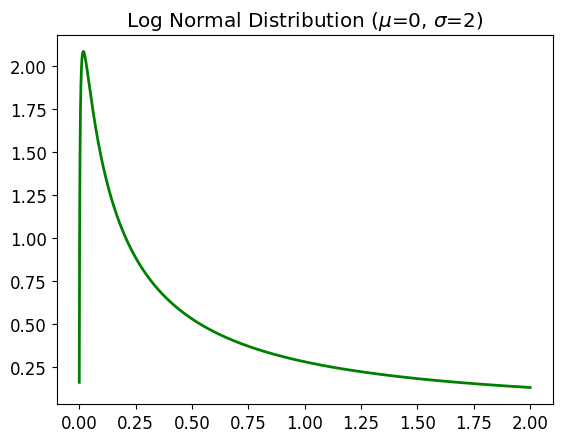

In [24]:
x = np.linspace(0, 2, 10000)
m=0
s=2

plt.rcParams.update({'font.size': 12})
plt.plot(x, log_normal_dist(m,s,x), 'g', linewidth=2)
plt.title("Log Normal Distribution")
plt.title(r'Log Normal Distribution ($\mu$='+ str(m) +', $\sigma$='+str(s)+')')
plt.savefig("images/log-normal_distribution_s="+str(s)+".png")